In [31]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
ANC_PATH = '/kaggle/input/lfw-positive-negative/content/data/anchor/face'
POS_PATH = '/kaggle/input/lfw-positive-negative/content/data/positive/face'
NEG_PATH = '/kaggle/input/lfw-positive-negative/content/data/negative/face'

In [4]:
anchor_files = [os.path.join(ANC_PATH, f) for f in os.listdir(ANC_PATH) if f.endswith('.jpg')]
positive_files = [os.path.join(POS_PATH, f) for f in os.listdir(POS_PATH) if f.endswith('.jpg')]
negative_files = [os.path.join(NEG_PATH, f) for f in os.listdir(NEG_PATH) if f.endswith('.jpg')]

In [5]:
anchor_files = anchor_files[:3000]
positive_files = positive_files[:3000]
negative_files = negative_files[:3000]

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
def preprocess(file_path):
    img = Image.open(file_path).convert("RGB")
    return transform(img)

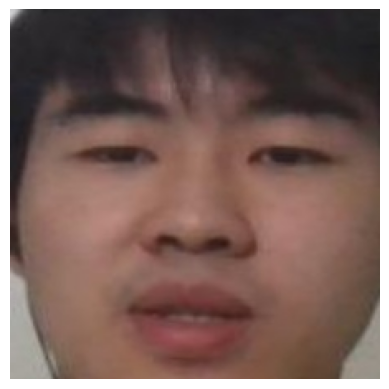

In [8]:
img = preprocess('/kaggle/input/lfw-positive-negative/content/data/anchor/face/13eaa162-ba39-11ef-b1cd-0242ac1c000c.jpg')
plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for visualization
plt.axis('off')
plt.show()

In [9]:
class SiameseDataset(Dataset):
    def __init__(self, anchor_files, positive_files, negative_files):
        self.anchor_files = anchor_files
        self.positive_files = positive_files
        self.negative_files = negative_files
        self.labels = torch.cat([
            torch.ones(len(anchor_files)),
            torch.zeros(len(anchor_files))
        ])

    def __len__(self):
        return len(self.anchor_files) * 2

    def __getitem__(self, idx):
        if idx < len(self.anchor_files):
            anchor_img = preprocess(self.anchor_files[idx])
            pos_img = preprocess(self.positive_files[idx])
            label = 1  
        else:
            idx = idx - len(self.anchor_files)
            anchor_img = preprocess(self.anchor_files[idx])
            neg_img = preprocess(self.negative_files[idx])
            label = 0  
        
        return anchor_img, pos_img if label == 1 else neg_img, label

In [10]:
dataset = SiameseDataset(anchor_files, positive_files, negative_files)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [11]:
for anchor, pair_img, label in dataloader:
    print(anchor.shape, pair_img.shape, label.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32])


(-0.5, 223.5, 223.5, -0.5)

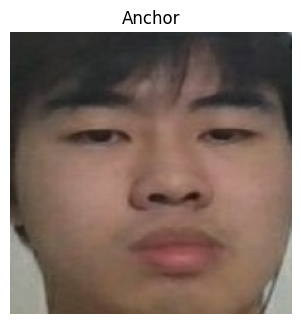

In [12]:
sample_anchor, sample_pair_img, sample_label = dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_anchor.permute(1, 2, 0))
plt.title("Anchor")
plt.axis('off')

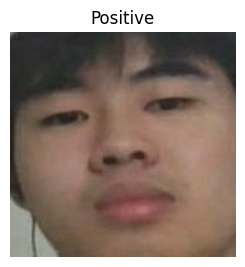

In [13]:
plt.subplot(1, 2, 2)
plt.imshow(sample_pair_img.permute(1, 2, 0))
plt.title("Positive" if sample_label == 1 else "Negative")
plt.axis('off')
plt.show()

In [14]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  

In [15]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
class VGGFaceEmbedding(nn.Module):
    def __init__(self):
        super(VGGFaceEmbedding, self).__init__()
        self.meta = {
            'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
            'std': [1, 1, 1],
            'imageSize': [224, 224, 3]
        }
        # Load pre-trained ResNet-50
        self.base_model = resnet50(pretrained=True)
        # Remove the final fully connected layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.base_model(x)
        x = self.pooling(x)
        x = self.flatten(x)
        return x

In [18]:
class L1Dist(nn.Module):
    def __init__(self):
        super(L1Dist, self).__init__()

    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)

In [19]:
def make_siamese_model():
    class SiameseNetwork(nn.Module):
        def __init__(self):
            super(SiameseNetwork, self).__init__()
            self.embedding = VGGFaceEmbedding()
            self.distance = L1Dist()
            self.fc1 = nn.Linear(2048, 512)  # Assuming embedding output size is 2048
            self.fc2 = nn.Linear(512, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, input_image, validation_image):
            input_embedding = self.embedding(input_image)
            validation_embedding = self.embedding(validation_image)
            distances = self.distance(input_embedding, validation_embedding)
            x = self.fc1(distances)
            x = self.fc2(x)
            x = self.sigmoid(x)
            return x

    return SiameseNetwork()

In [20]:
siamese_model = make_siamese_model()
print(siamese_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SiameseNetwork(
  (embedding): VGGFaceEmbedding(
    (base_model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [22]:
binary_cross_entropy_loss = nn.BCELoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_step(batch, model, loss_fn, optimizer):
    model.train()
    input_image, validation_image, labels = batch
    # Move to device and convert labels to float
    input_image = input_image.to(device)
    validation_image = validation_image.to(device)
    labels = labels.float().to(device)
    
    # Forward pass
    predictions = model(input_image, validation_image).squeeze()
    loss = loss_fn(predictions, labels)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(data_loader, model, loss_fn):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_image, validation_image, labels = batch
            # Move to device and convert labels to float
            input_image = input_image.to(device)
            validation_image = validation_image.to(device)
            labels = labels.float().to(device)
            
            predictions = model(input_image, validation_image).squeeze()
            loss = loss_fn(predictions, labels)
            val_loss += loss.item()
            predicted = (predictions > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return val_loss / len(data_loader), accuracy

def train(data_loader, val_loader, model, loss_fn, optimizer, epochs, patience=5):
    try:
        print(f"Training on {device}")
        model = model.to(device)
        
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False
        
        for epoch in range(epochs):
            if early_stop:
                print("Early stopping triggered.")
                break
                
            print(f"\nEpoch {epoch + 1}/{epochs}")
            epoch_loss = 0.0
            model.train()
            
            for batch_idx, batch in enumerate(data_loader):
                loss = train_step(batch, model, loss_fn, optimizer)
                epoch_loss += loss
                if (batch_idx + 1) % 10 == 0:
                    print(f"Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss:.4f}")
            
            train_loss = epoch_loss / len(data_loader)
            val_loss, val_accuracy = validate(val_loader, model, loss_fn)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # Optionally, save the best model
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    early_stop = True
        
        # Plot metrics
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss vs Epochs")
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Validation Accuracy vs Epochs")
        plt.show()
        
        return train_losses, val_losses, val_accuracies
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        # Ensure we still return the lists even if training fails partway through
        return train_losses, val_losses, val_accuracies

Training on cuda

Epoch 1/20
Batch 10/132, Loss: 0.6358
Batch 20/132, Loss: 0.6094
Batch 30/132, Loss: 0.5468
Batch 40/132, Loss: 0.4482
Batch 50/132, Loss: 0.2619
Batch 60/132, Loss: 0.0957
Batch 70/132, Loss: 0.0706
Batch 80/132, Loss: 0.0748
Batch 90/132, Loss: 0.0106
Batch 100/132, Loss: 0.0887
Batch 110/132, Loss: 0.0390
Batch 120/132, Loss: 0.0426
Batch 130/132, Loss: 0.0628
Epoch 1 - Train Loss: 0.2535, Val Loss: 0.3679, Val Accuracy: 0.7367

Epoch 2/20
Batch 10/132, Loss: 0.0126
Batch 20/132, Loss: 0.0162
Batch 30/132, Loss: 0.0009
Batch 40/132, Loss: 0.0210
Batch 50/132, Loss: 0.0005
Batch 60/132, Loss: 0.0025
Batch 70/132, Loss: 0.0003
Batch 80/132, Loss: 0.0007
Batch 90/132, Loss: 0.0020
Batch 100/132, Loss: 0.0054
Batch 110/132, Loss: 0.0283
Batch 120/132, Loss: 0.0015
Batch 130/132, Loss: 0.0036
Epoch 2 - Train Loss: 0.0193, Val Loss: 0.4324, Val Accuracy: 0.7922

Epoch 3/20
Batch 10/132, Loss: 0.0006
Batch 20/132, Loss: 0.0014
Batch 30/132, Loss: 0.0139
Batch 40/132, Loss

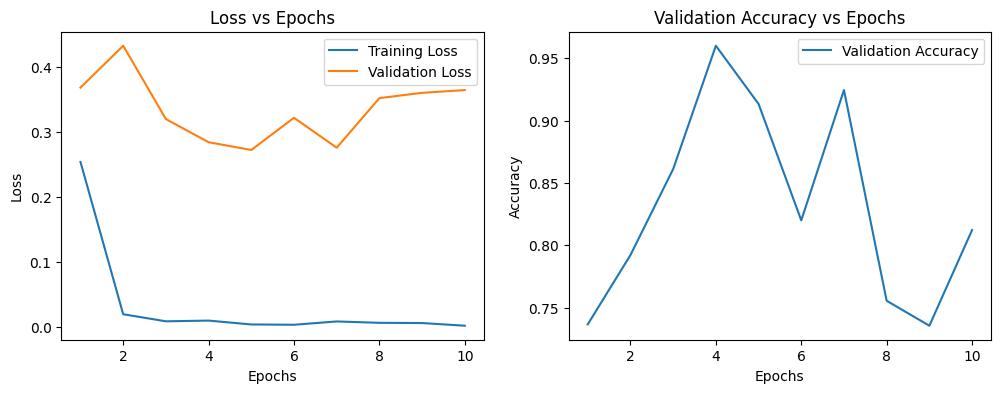

In [23]:
EPOCHS = 20
train_losses, val_losses, val_accuracies = train(
    train_loader, 
    val_loader, 
    siamese_model, 
    binary_cross_entropy_loss, 
    optimizer, 
    EPOCHS,
)

In [32]:
model_cpu = siamese_model.to("cpu")

In [33]:
torch.save(model_cpu.state_dict(), "model_cpu.pth")

In [35]:
siamese_model.load_state_dict(torch.load('/kaggle/working/model_cpu.pth'))
siamese_model.eval()

<ipython-input-35-36a0e2948021>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_model.load_state_dict(torch.load('/kaggle/working/model_cpu.pth'))


SiameseNetwork(
  (embedding): VGGFaceEmbedding(
    (base_model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [36]:
def find_best_threshold(y_true, y_pred_proba):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Initialize metrics for each threshold
    metrics = {}
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Store metrics for this threshold
        metrics[threshold] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Find best thresholds for each metric
    best_thresholds = {
        'accuracy': max(metrics.items(), key=lambda x: x[1]['accuracy'])[0],
        'precision': max(metrics.items(), key=lambda x: x[1]['precision'])[0],
        'recall': max(metrics.items(), key=lambda x: x[1]['recall'])[0],
        'f1': max(metrics.items(), key=lambda x: x[1]['f1'])[0],
        'youden': thresholds[np.argmax(tpr - fpr)]  # Youden's J statistic
    }
    
    return best_thresholds, metrics

In [37]:
def evaluate_siamese_model(siamese_model, test_loader, plot_roc=True):
    all_y_true = []
    all_y_prob = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    siamese_model.to(device)
    siamese_model.eval()

    # Collect predictions
    with torch.no_grad():
        for anchor_img, paired_img, y_true in test_loader:
            anchor_img = anchor_img.to(device)
            paired_img = paired_img.to(device)
            y_true = y_true.to(device)
            y_hat = siamese_model(anchor_img, paired_img)
            y_prob = torch.sigmoid(y_hat).squeeze().cpu().numpy()
            all_y_true.extend(y_true.cpu().numpy())
            all_y_prob.extend(y_prob)

    all_y_true = np.array(all_y_true)
    all_y_prob = np.array(all_y_prob)

    fpr, tpr, thresholds = roc_curve(all_y_true, all_y_prob)
    
    optimal_thresholds = {}
    best_metrics = {}
    
    best_f1 = 0
    best_accuracy = 0
    best_youden = 0
    
    for threshold in thresholds:
        y_pred = (all_y_prob >= threshold).astype(int)
        
        current_accuracy = accuracy_score(all_y_true, y_pred)
        current_f1 = f1_score(all_y_true, y_pred)
        current_youden = tpr[list(thresholds).index(threshold)] - fpr[list(thresholds).index(threshold)]

        if current_f1 > best_f1:
            best_f1 = current_f1
            optimal_thresholds['f1'] = threshold
            
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            optimal_thresholds['accuracy'] = threshold
            
        if current_youden > best_youden:
            best_youden = current_youden
            optimal_thresholds['youden'] = threshold

    best_threshold = optimal_thresholds['f1']
    final_predictions = (all_y_prob >= best_threshold).astype(int)
    
    # Calculate final metrics
    metrics = {
        'accuracy': accuracy_score(all_y_true, final_predictions),
        'precision': precision_score(all_y_true, final_predictions),
        'recall': recall_score(all_y_true, final_predictions),
        'f1': f1_score(all_y_true, final_predictions),
        'roc_auc': roc_auc_score(all_y_true, all_y_prob)
    }
    
    # Plot ROC curve if requested
    if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    # Print results
    print("\nOptimal Thresholds:")
    for metric, threshold in optimal_thresholds.items():
        print(f"{metric}: {threshold:.3f}")
        
    print("\nMetrics using F1-optimal threshold ({:.3f}):".format(best_threshold))
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nClass Distribution:", np.unique(all_y_true, return_counts=True))
    
    return metrics, optimal_thresholds, final_predictions

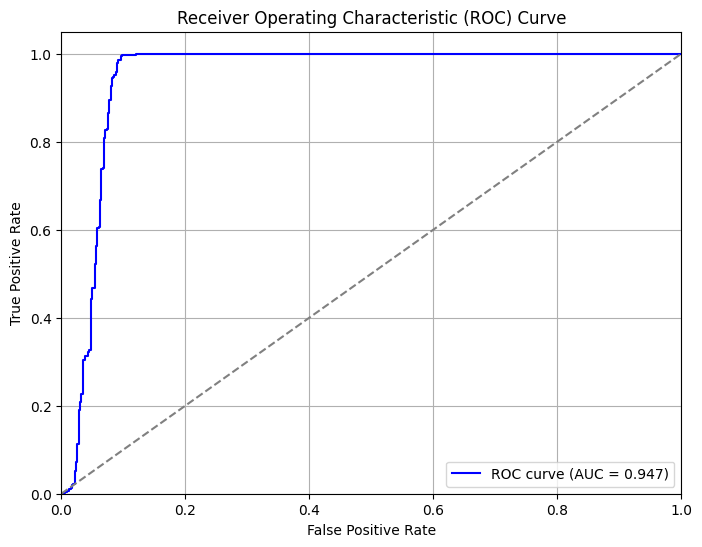


Optimal Thresholds:
accuracy: 0.588
f1: 0.583
youden: 0.583

Metrics using F1-optimal threshold (0.583):
accuracy: 0.9478
precision: 0.9040
recall: 0.9977
f1: 0.9485
roc_auc: 0.9475

Class Distribution: (array([0, 1]), array([466, 434]))


In [38]:
metrics, optimal_thresholds, predictions = evaluate_siamese_model(siamese_model, test_loader)

In [39]:
all_y_true = []
all_y_pred = []
all_y_prob = []  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_model.to(device)
siamese_model.eval()  
with torch.no_grad():
    for anchor_img, paired_img, y_true in test_loader:
        anchor_img = anchor_img.to(device)
        paired_img = paired_img.to(device)
        y_true = y_true.to(device)
        y_hat = siamese_model(anchor_img, paired_img)
        y_prob = torch.sigmoid(y_hat).squeeze().cpu().numpy() 
        y_pred = [1.0 if prob > 0.588 else 0.0 for prob in y_prob]  
        all_y_true.extend(y_true.cpu().numpy())
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)

print("Predictions:", all_y_pred)
print("True Labels:", all_y_true)

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred)
recall = recall_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)
roc_auc = roc_auc_score(all_y_true, all_y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("Class Distribution:", np.unique(all_y_true, return_counts=True))

Predictions: [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1

In [40]:
print(classification_report(all_y_pred, all_y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.95       424
         1.0       0.99      0.91      0.95       476

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



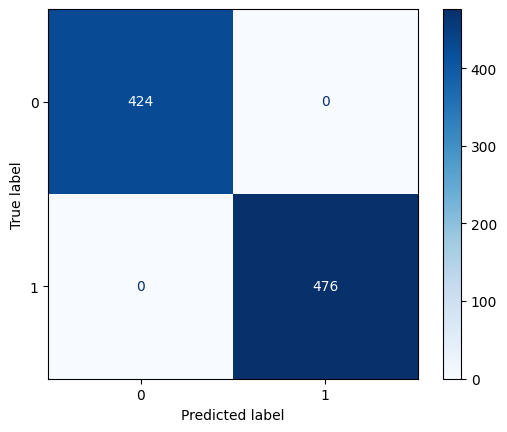

In [42]:
cm = confusion_matrix(all_y_pred, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [43]:
def verify_faces(model, image_path1, image_path2, threshold=None):
    if threshold is None:
        threshold = 0.5
    
    if not os.path.exists(image_path1):
        raise FileNotFoundError(f"Image 1 not found: {image_path1}")
    if not os.path.exists(image_path2):
        raise FileNotFoundError(f"Image 2 not found: {image_path2}")
    
    transform = transforms.Compose([
        transforms.Resize((100, 100)), 
        transforms.ToTensor(),
    ])
    
    try:
        img1 = Image.open(image_path1).convert('RGB')
        img2 = Image.open(image_path2).convert('RGB')
        
        img1 = transform(img1)
        img2 = transform(img2)
        
        img1 = img1.unsqueeze(0)
        img2 = img2.unsqueeze(0)
        
    except Exception as e:
        raise Exception(f"Error processing images: {str(e)}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img1 = img1.to(device)
    img2 = img2.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img1, img2)
        probability = torch.sigmoid(output).item()
        prediction = 1 if probability >= threshold else 0

    result = {
        'same_person': bool(prediction),
        'probability': probability,
        'threshold_used': threshold,
        'image1_path': image_path1,
        'image2_path': image_path2
    }
    
    return result

In [44]:
image1_path = "/kaggle/input/lfw-positive-negative/content/data/anchor/face/13eaa162-ba39-11ef-b1cd-0242ac1c000c.jpg"
image2_path = "/kaggle/input/lfw-positive-negative/content/data/positive/face/2299b6cc-ba38-11ef-b1cd-0242ac1c000c.jpg"

optimal_threshold = 0.542 

# Make prediction
result = verify_faces(siamese_model, image1_path, image2_path, threshold=optimal_threshold)

# Print results
print(f"Images show the same person: {result['same_person']}")
print(f"Confidence: {result['probability']:.3f}")

Images show the same person: True
Confidence: 0.627
